In [1]:
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/BregmanClustering.git --no-deps
!pip install torch_geometric
### Uncomment line below if in Google Colab environment
!chmod 777 /usr/local/lib/python3.9/dist-packages/BregmanTests/install_algos.sh
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/FelipeSchreiber/BregmanClustering.git to /tmp/pip-req-build-awyfsh1j
  Running command git clone --filter=blob:none --quiet https://github.com/FelipeSchreiber/BregmanClustering.git /tmp/pip-req-build-awyfsh1j
  Resolved https://github.com/FelipeSchreiber/BregmanClustering.git to commit c9b7c538d1d5c5ece27fda15ef131ae0efcea87b
  Preparing metadata (setup.py) ... done
  Created wheel for bregClust: filename=bregClust-1.0-py3-none-any.whl size=21310 sha256=1ed8fc36e322e9ba37b11de8a1bed4ce565051fec59832b9089244cc8f2ceec7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ldq5ro0i/wheels/6f/8f/ab/2faa84d8b9fad58989d72cda12225f6191888313b2d42f6ad5
Successfully built bregClust
  Attempting uninstall: bregClust
    Found existing installation: bregClust 1.0
    Uninstalling bregClust-1.0:
      Successfully uninstalled bregClust-1.0
Looking in indexes: https://pypi.org

In [2]:
#%matplotlib inline
from BregmanTests.WSBM import *
from BregmanTests.utils import *
import BregmanTests
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
#from signet.cluster import Cluster
import scipy.sparse as ss
import pandas as pd
import os
import warnings
from BregmanClustering import models
from BregmanClustering.models import SoftBregmanNodeAttributeGraphClustering as VEMbreg
from BregmanClusteringTorch.torch_models import SoftBregmanClusteringTorch as torchBreg
from BregmanClusteringTorch.torch_models import  SoftBregmanClusteringTorchSparse as sparseBreg
from BregmanClusteringTorch.torch_models import GNNBregmanClustering as gnnBreg
import subprocess
warnings.filterwarnings("ignore")

In [3]:
from BregmanTests import cfg

In [4]:
cfg.base_path

'/usr/local/lib/python3.9/dist-packages/BregmanTests'

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 17:08:00 2023

@author: maximilien, Felipe Schreiber
"""
from tqdm import tqdm

In [6]:
c = 3 ## number of communities
n = 100 ##size per community (or you can pass a list with different sizes)
r = 10 ##specify how far the attributes distributions are from the origin
d = 2 ##number of attributes
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])

In [7]:
X,Y,true_labels,G = BregmanBenchmark(P,[n]*c,1,10,dims=d,weight_variance=0.01,att_variance=0.1,\
                       weight_distribution="logistic",attributes_distribution="logistic",radius=r,return_G=True).generate_benchmark_WSBM()
A = (X != 0).astype(int)

In [8]:
X

array([[0.        , 0.9877952 , 0.87251735, ..., 0.        , 4.59089044,
        0.        ],
       [0.9877952 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.87251735, 0.        , 0.        , ..., 4.51902613, 0.        ,
        4.60789298],
       ...,
       [0.        , 0.        , 4.51902613, ..., 0.        , 0.        ,
        9.95870344],
       [4.59089044, 0.        , 0.        , ..., 0.        , 0.        ,
        9.84578221],
       [0.        , 0.        , 4.60789298, ..., 9.95870344, 9.84578221,
        0.        ]])

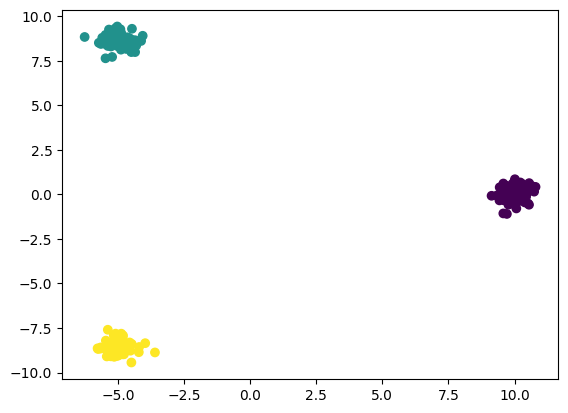

In [9]:
plt.scatter(Y[:,0],Y[:,1],c=true_labels)

In [10]:
pred_labels = spectral(X.copy(),c)
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

1.0 1.0


In [11]:
pred_labels = GaussianMixture(n_components=c).fit_predict(Y.copy())
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

1.0 1.0


In [12]:
#model = torchBreg(n_clusters=c,normalize_=True,thresholding=True)
model = sparseBreg(n_clusters=c,normalize_=True,thresholding=True)
model.fit(A, Y)
z_pred_both = model.predict(A,Y)
print(adjusted_rand_score(true_labels, z_pred_both),normalized_mutual_info_score(true_labels, z_pred_both))

Initialisation chosen from the attributes
0
1.0 1.0


In [13]:
import networkx as nx
nx.adjacency_matrix(G).todense() 

array([[0.        , 0.9877952 , 0.87251735, ..., 0.        , 4.59089044,
        0.        ],
       [0.9877952 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.87251735, 0.        , 0.        , ..., 4.51902613, 0.        ,
        4.60789298],
       ...,
       [0.        , 0.        , 4.51902613, ..., 0.        , 0.        ,
        9.95870344],
       [4.59089044, 0.        , 0.        , ..., 0.        , 0.        ,
        9.84578221],
       [0.        , 0.        , 4.60789298, ..., 9.95870344, 9.84578221,
        0.        ]])

In [14]:
G.nodes[130]["attr"]

array([-4.80713283,  8.84167533,  0.        ])

In [15]:
model = gnnBreg(n_clusters=c,normalize_=False,thresholding=True,epochs=100)
model.fit(G, Y)
z_pred_both = model.predict(G, Y)
print(adjusted_rand_score(true_labels, z_pred_both),normalized_mutual_info_score(true_labels, z_pred_both))

Initialisation chosen from the attributes
0.9605467603426407 0.94878832043511


In [16]:
from BregmanClustering.models import BregmanNodeEdgeAttributeGraphClustering as edgeBreg
from BregmanTests.install_algorithms import main as install_env
import BregmanTests
## Optional: set repository for CRAN
BregmanTests.cfg.CRAN_repo = "https://cran.fiocruz.br/"
install_env()
from CSBM.Python.functions import *


Installing R packages...
 This step takes about 5 min...



(as ‘lib’ is unspecified)

















	‘/tmp/RtmpKyzc54/downloaded_packages’



In [17]:
from copy import deepcopy

In [18]:
n_average = 10
n = 300
n_clusters = 2
d = 1
sizes = [ n // n_clusters ]*np.ones( n_clusters, dtype = int )

b = 5
pout = b * np.log( n ) / n

a_range = [ 5,7,9,11,13,15 ]
r_range = [ 0,1,2,3,4,5 ]
# a_range = [ 5,7,9]
# r_range = [ 0,1,2]

stats = {"varying":[],"a":[],"r":[],"agreed":[],"ARI_chernoff":[],"ARI_AIC":[],"ARI_ORACLE":[]}

for varying in ["attributes","graph"]:
# varying = 'attributes'
# #varying = 'graph'

    aris_attributes_mean = [ ]
    aris_graph_mean = [ ]
    aris_both_mean = [ ]
    aris_attSBM_mean = [ ]
    aris_IR_sLS_mean = [ ]
    aris_IR_LS_mean = [ ]
    aris_both2_mean = [ ]
    aris_oracle_mean = [ ]

    aris_attributes_std = [ ]
    aris_graph_std = [ ]
    aris_both_std = [ ]
    aris_attSBM_std = [ ]
    aris_IR_sLS_std = [ ]
    aris_IR_LS_std = [ ]
    aris_both2_std = [ ]
    aris_oracle_std = [ ]

    if varying == 'graph':
        loop = tqdm( range( len( a_range ) ) )
    else:
        loop = tqdm( range( len( r_range ) ) )

    for dummy in loop:
        if varying == 'graph':
            a = a_range[ dummy ]
            r = 1
        elif varying == 'attributes':
            a = 8
            r = r_range[ dummy ]

        pin = a * np.log( n ) / n
        p = (pin- pout) * np.eye( n_clusters ) + pout * np.ones( (n_clusters, n_clusters) )

        aris_attributes = [ ]
        aris_graph = [ ]
        aris_both = [ ]
        aris_attSBM = [ ]
        aris_IR_sLS  = [ ]
        aris_IR_LS = [ ]
        aris_both2 = [ ]
        aris_oracle = [ ]
        
        path_ = BregmanTests.cfg.path_to_data+f"a/{a}/r/{r}/"
        if not os.path.exists(path_):
            os.makedirs(path_)

        total = 0
        for trial in range( n_average ):
            ( X, Y, z_true, G) = BregmanBenchmark(p,sizes,att_variance=1,\
                    attributes_distribution="gaussian",radius=r,return_G=True).generate_benchmark_WSBM()
            
            X = (X != 0).astype(int)
            model = models.BregmanNodeAttributeGraphClustering( n_clusters = n_clusters, initializer="chernoff")
            ## For comparison purposes, the initialization is the same for IR-sLS, IR-LS and ours    
            model.initialize(X,Y)
            model.assignInitialLabels( X, Y )
            z_init = deepcopy(model.predicted_memberships)
            chernoff_init_graph = model.graph_init
            chernoff_graph_labels = model.memberships_from_graph
            chernoff_att_labels = model.memberships_from_attributes

            with open(f'{path_}att_{trial}.npy', 'wb') as g:
                np.save(g, Y)
            with open(f'{path_}net_{trial}.npy', 'wb') as g:
                np.save(g, X)
            with open(f'{path_}z_init_{trial}.npy', 'wb') as g:
                np.save(g, convertZ(z_init)+1)

            model.fit( X, Y )
            z_pred_both = model.predict( X, Y )
            z_pred_graph = models.frommembershipMatriceToVector( chernoff_graph_labels )
            z_pred_attributes = models.frommembershipMatriceToVector( chernoff_att_labels )
            
            # this code is for initialization comparison
            ### > Start
            # if chernoff_init_graph == model.AIC_initializer(X,Y).graph_init:
            #     total += 1
            
            # ## Warm start
            # if model.graph_init:
            #     model.fit( X, Y, chernoff_graph_labels)
            # else:
            #     model.fit(X, Y, chernoff_att_labels)
            ### > end

            model2 = edgeBreg(n_clusters=n_clusters, initializer="chernoff")
            z_pred_both2 = model2.fit(X,X.reshape(n,n,1),Y,z_init).predict( X, Y )
            
            IR_sLS_pred = iter_csbm(X,Y,z_init,n_clusters)
            IR_LS_pred = iter_csbm2(X,Y,z_init,n_clusters)
                
            subprocess.call(["/usr/bin/Rscript","--vanilla",f"{BregmanTests.cfg.base_path}/run_AttSBM.r",\
                            f'{path_}att_{trial}.npy',\
                            f'{path_}net_{trial}.npy',\
                            f'{path_}z_init_{trial}.npy'])
            attSBMPred = np.load("predict.npy")

            aris_attributes.append( adjusted_rand_score( z_true, z_pred_attributes ) )
            aris_graph.append( adjusted_rand_score( z_true, z_pred_graph ) )
            aris_both.append( adjusted_rand_score( z_true, z_pred_both ) )
            aris_attSBM.append( adjusted_rand_score( z_true, attSBMPred ) )
            aris_IR_sLS.append( adjusted_rand_score( z_true, IR_sLS_pred ) )
            aris_IR_LS.append( adjusted_rand_score( z_true, IR_LS_pred ) )
            aris_both2.append( adjusted_rand_score( z_true, z_pred_both2 ))
            
            if chernoff_init_graph != model.AIC_initializer(X,Y).graph_init:
                ## both initializations were done
                aris_oracle.append( max(aris_both[-1],aris_both2[-1]))
            elif chernoff_init_graph:
                z_pred_att_init = model.fit(X,Y,chernoff_att_labels).predict(X,Y)
                ari_att_init = adjusted_rand_score( z_true, z_pred_att_init)
                aris_oracle.append( max(aris_both[-1], ari_att_init))
            elif not chernoff_init_graph:
                z_pred_graph_init = model.fit(X,Y,chernoff_graph_labels).predict(X,Y)
                ari_graph_init = adjusted_rand_score( z_true, z_pred_graph_init)
                aris_oracle.append( max(aris_both[-1], ari_graph_init))
                
        aris_attributes_mean.append( np.mean( aris_attributes ) )
        aris_graph_mean.append( np.mean( aris_graph ) )
        aris_both_mean.append( np.mean( aris_both ) )
        aris_attSBM_mean.append( np.mean( aris_attSBM ) )
        aris_IR_sLS_mean.append( np.mean( aris_IR_sLS ) )
        aris_IR_LS_mean.append( np.mean( aris_IR_LS ) )
        aris_both2_mean.append( np.mean( aris_both2) )
        aris_oracle_mean.append( np.mean( aris_oracle) )
        
        aris_attributes_std.append( np.std( aris_attributes ) )
        aris_graph_std.append( np.std( aris_graph ) )
        aris_both_std.append( np.std( aris_both ) )
        aris_attSBM_std.append( np.std( aris_attSBM ) )
        aris_IR_sLS_std.append( np.std( aris_IR_sLS ) )
        aris_IR_LS_std.append( np.std( aris_IR_LS ) )
        aris_both2_std.append( np.std( aris_both2 ) )
        aris_oracle_std.append( np.std( aris_oracle) )
        
        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["agreed"].append(total/n_average)
        stats["ARI_chernoff"].append(aris_both_mean[-1])
        stats["ARI_AIC"].append(aris_both2_mean[-1])
        stats["ARI_ORACLE"].append(aris_oracle_mean[-1])
        
    curves = [ aris_attributes_mean, aris_graph_mean,\
              aris_both_mean , aris_attSBM_mean, aris_IR_sLS_mean,\
              aris_IR_LS_mean, aris_both2_mean]

    curves_std = [ aris_attributes_std, aris_graph_std,\
                  aris_both_std , aris_attSBM_std, aris_IR_sLS_std,\
                  aris_IR_LS_std, aris_both2_std]

    labels = [ 'attributes', 'graph', 'both' , 'attSBM', 'IR_sLS', 'IR_LS', "edgeBreg"]
    saveFig = True
    if varying == 'graph':    
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_b_' + str(b) + '_r_' + str(r) +  '_nAverage' + str(n_average) + '.jpeg'
        plotting( a_range, curves, labels, curves_std = curves_std, xticks = a_range, xlabel = 'a', saveFig = saveFig, fileName = fileName )
        plt.close()
    elif varying == 'attributes':
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_a_' + str(a) + '_b_' + str(b) +  '_nAverage_' + str(n_average) + '.jpeg'
        plotting( r_range, curves, labels, curves_std = curves_std, xticks = r_range, xlabel = 'r', saveFig = saveFig, fileName = fileName )
        plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of 

 17%|█▋        | 1/6 [02:33<12:48, 153.78s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the grap

 33%|███▎      | 2/6 [04:59<09:56, 149.04s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from th

 50%|█████     | 3/6 [07:25<07:23, 147.87s/it]

number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
In

 67%|██████▋   | 4/6 [10:04<05:03, 151.96s/it]

Initialisation chosen from the attributes
Initialisation chosen from the attributes
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attribut

 83%|████████▎ | 5/6 [12:46<02:35, 155.52s/it]

number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the attributes
Initialisation chosen from the attributes
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
number of iterations :  25
Initial

100%|██████████| 6/6 [15:15<00:00, 152.54s/it]

Initialisation chosen from the attributes



  0%|          | 0/6 [00:00<?, ?it/s]

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of 

 17%|█▋        | 1/6 [02:19<11:36, 139.34s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from 

 33%|███▎      | 2/6 [04:38<09:16, 139.12s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the grap

 50%|█████     | 3/6 [07:15<07:22, 147.37s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisatio

 67%|██████▋   | 4/6 [10:08<05:14, 157.33s/it]

Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initi

 83%|████████▎ | 5/6 [12:50<02:39, 159.25s/it]

number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the attributes
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the grap

100%|██████████| 6/6 [15:30<00:00, 155.15s/it]

number of iterations :  25


In [19]:
import pandas as pd
df = pd.DataFrame.from_dict(stats)

In [20]:
df

,varying,a,r,agreed,ARI_chernoff,ARI_AIC,ARI_ORACLE
0,attributes,8,0,0.0,0.239995,0.539788,0.241886
1,attributes,8,1,0.0,0.842491,0.828984,0.843727
2,attributes,8,2,0.0,0.980098,0.978773,0.980098
3,attributes,8,3,0.0,0.997333,0.997333,0.997333
4,attributes,8,4,0.0,1.000000,1.000000,1.000000
5,attributes,8,5,0.0,1.000000,1.000000,1.000000
6,graph,5,1,0.0,0.000137,0.001393,0.185777
7,graph,7,1,0.0,0.444239,0.450697,0.577269
8,graph,9,1,0.0,0.948713,0.946127,0.948713
9,graph,11,1,0.0,1.000000,0.998667,1.000000
